## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

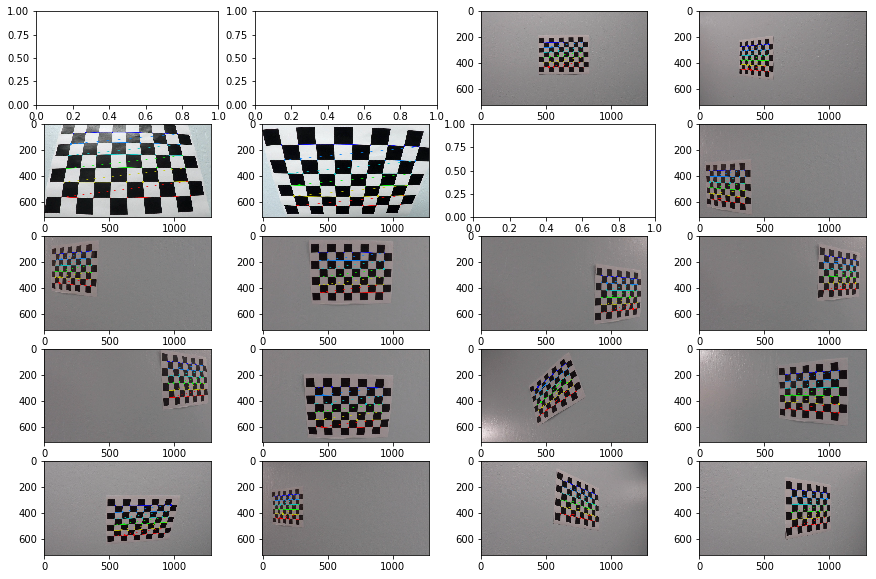

In [8]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Set matplotlib parameters
# revel: 
f, ax = plt.subplots(5, 4, figsize=(15, 10))
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Draw and display the corners
        img = Image.fromarray(img, 'RGB')
        ax[i].imshow(img)
        #print('DONE')
    #else:
        #print('ERROR')

In [9]:
# numpy.ravel() method
test_1 = np.array([[1, 2 ], [3, 4, 5]])
print('array')
print(test_1)
print('success rabeled')
print(np.ravel(test_1))

test_2 = np.array([[1, 2, 6], [3, 4, 5]])
print('array')
print(test_2)
print('success rabeled')
print(np.ravel(test_2))

array
[list([1, 2]) list([3, 4, 5])]
success rabeled
[list([1, 2]) list([3, 4, 5])]
array
[[1 2 6]
 [3 4 5]]
success rabeled
[1 2 6 3 4 5]


## Apply a distortion correction to raw images.

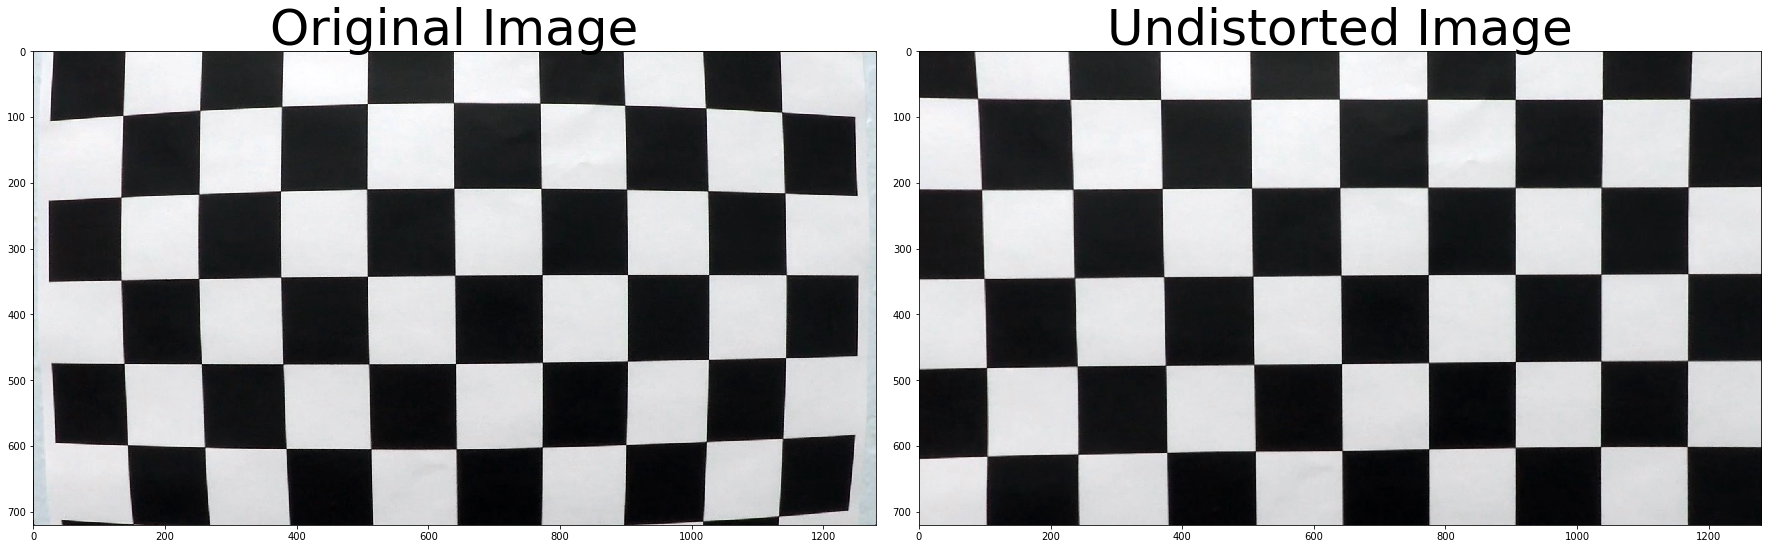

In [10]:
img = cv2.imread('camera_cal/calibration1.jpg')
#plt.imshow(img)

# Undistort method
def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dist = cv2.undistort(img, mtx, dist, None, mtx)
    return dist

undist = undistort_image(img, objpoints, imgpoints)
    
# Display images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Use color transforms, gradients, etc., to create a thresholded binary image.

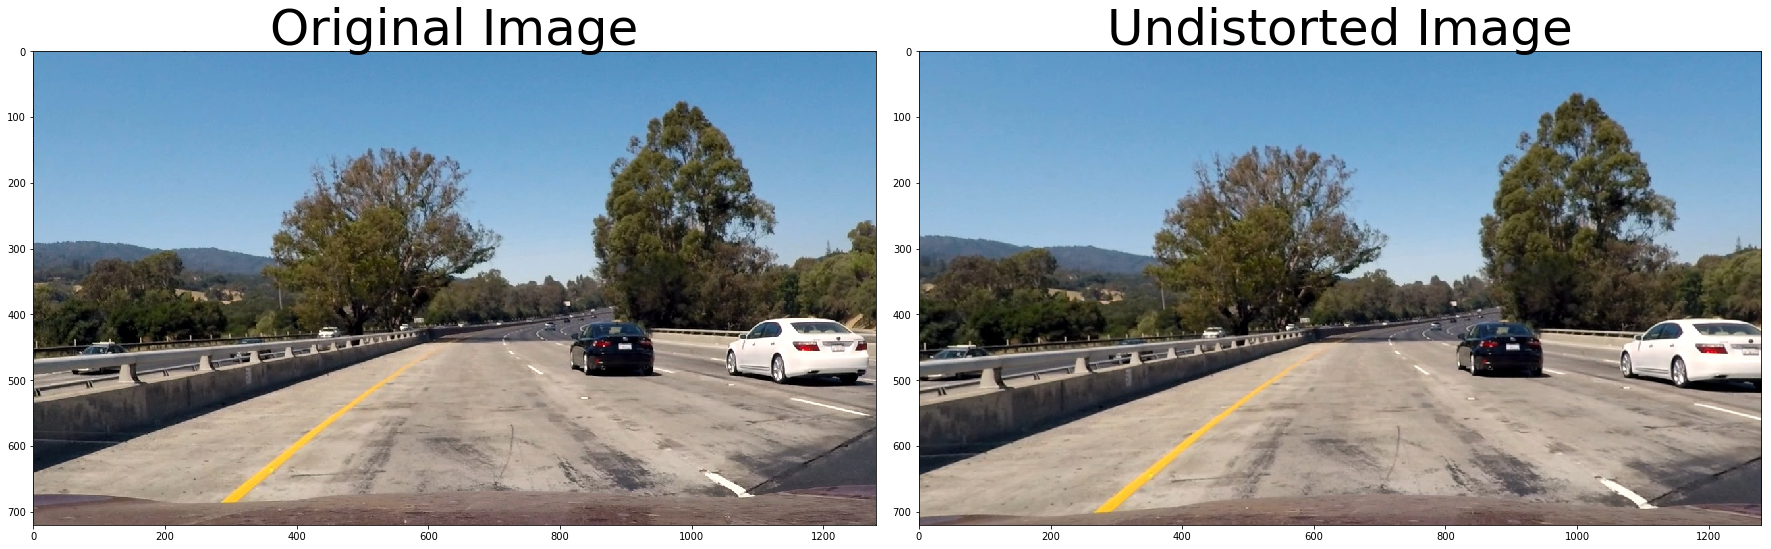

In [179]:
## Undisort test image.

# Here is not cv2.imread but mpimg.imread because cv2.imread will change image color.
test_img = mpimg.imread('./test_images/test1.jpg')

test_undist = undistort_image(test_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

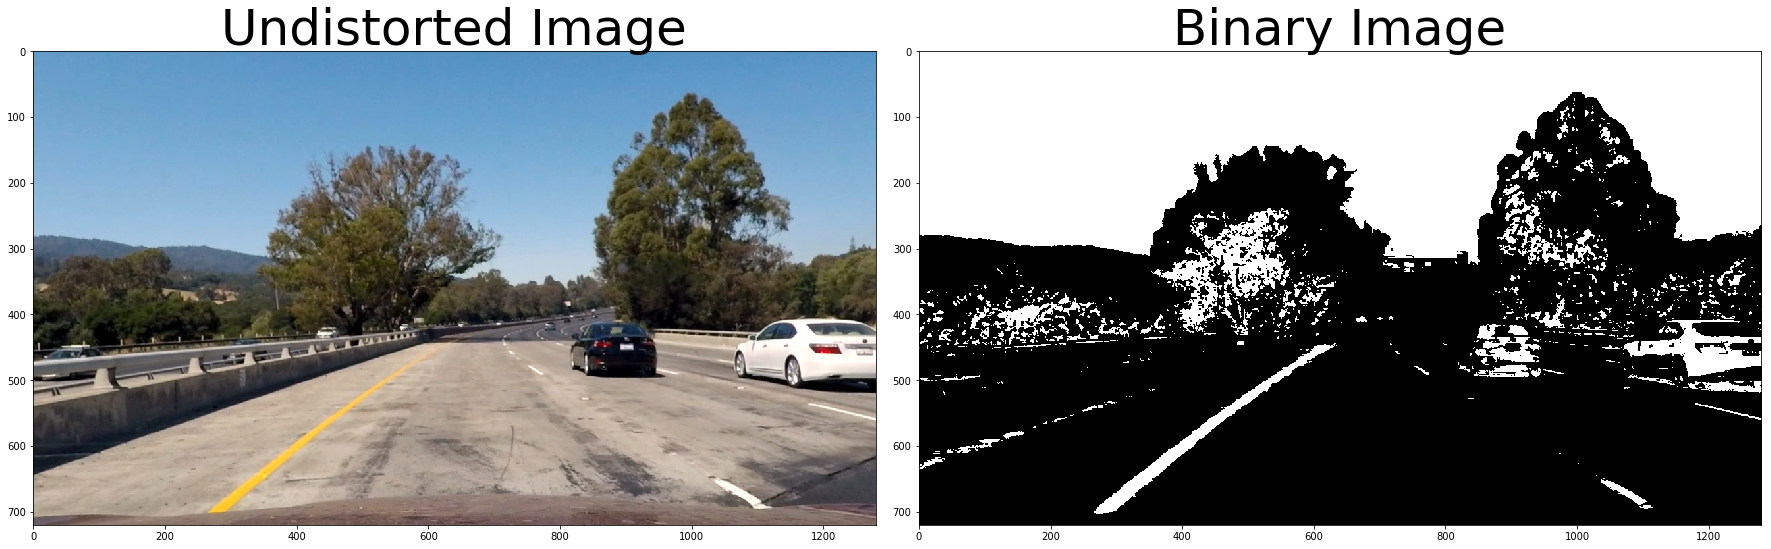

In [180]:
## Create binary image by using color transforms.

def hls_select(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

test_binary = hls_select(test_undist, thresh=(90, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_undist)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(test_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

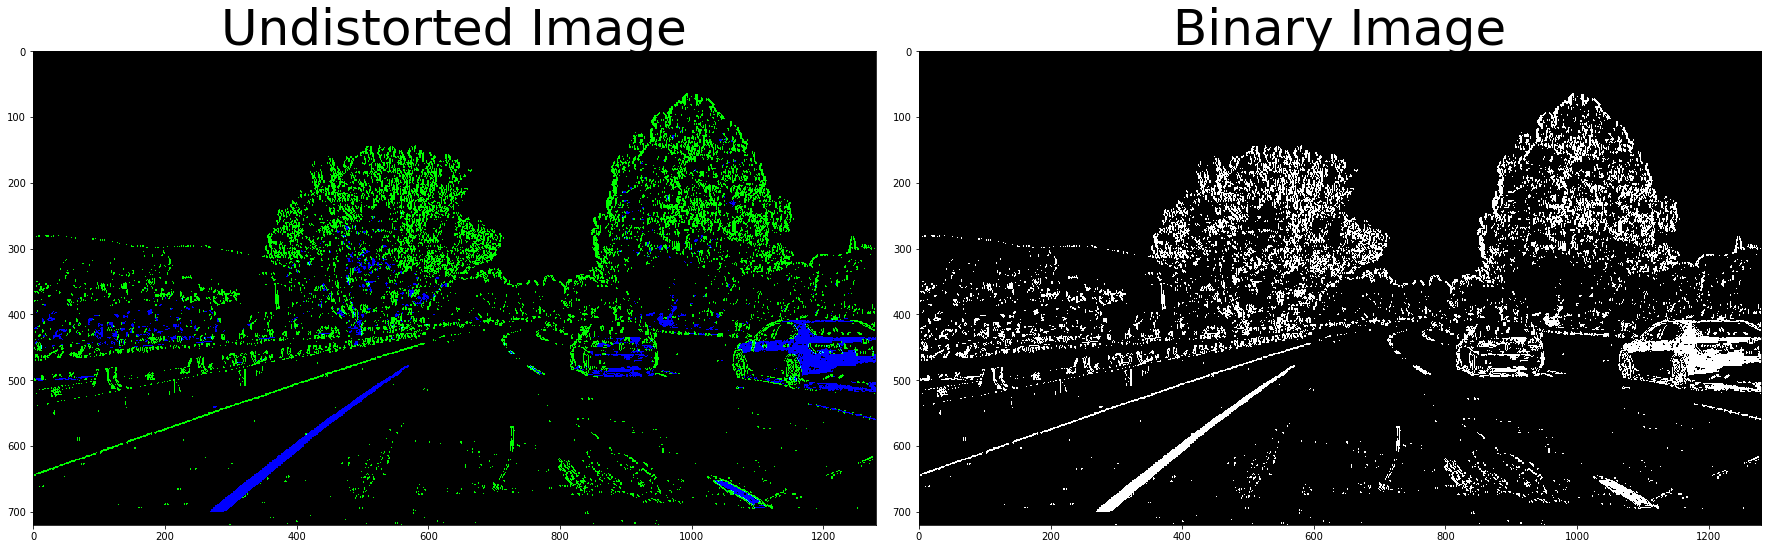

In [181]:
## Create binary image by using gradients.

def pipline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |  (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

color_binary, combined_binary = pipline(test_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [182]:
def unwarp(img, src, dst):
    height, width = img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped

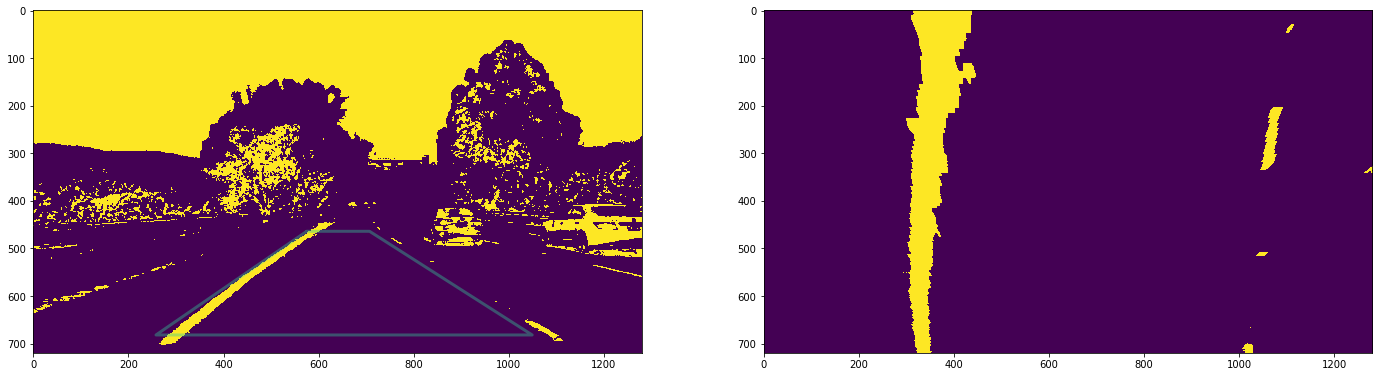

In [237]:
img_size = test_binary.shape
offset = 300

src = np.float32([
                  (575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)]
    )
dst = np.float32([
                  (offset,0),
                  (width-offset,0),
                  (offset,height),
                  (width-offset,height)]
    )

warped_image = unwarp(test_binary, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_binary)
x = [src[0][0], src[2][0], src[3][0], src[1][0],src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.imshow(warped_image)

(720, 1280)
360
(1280,)


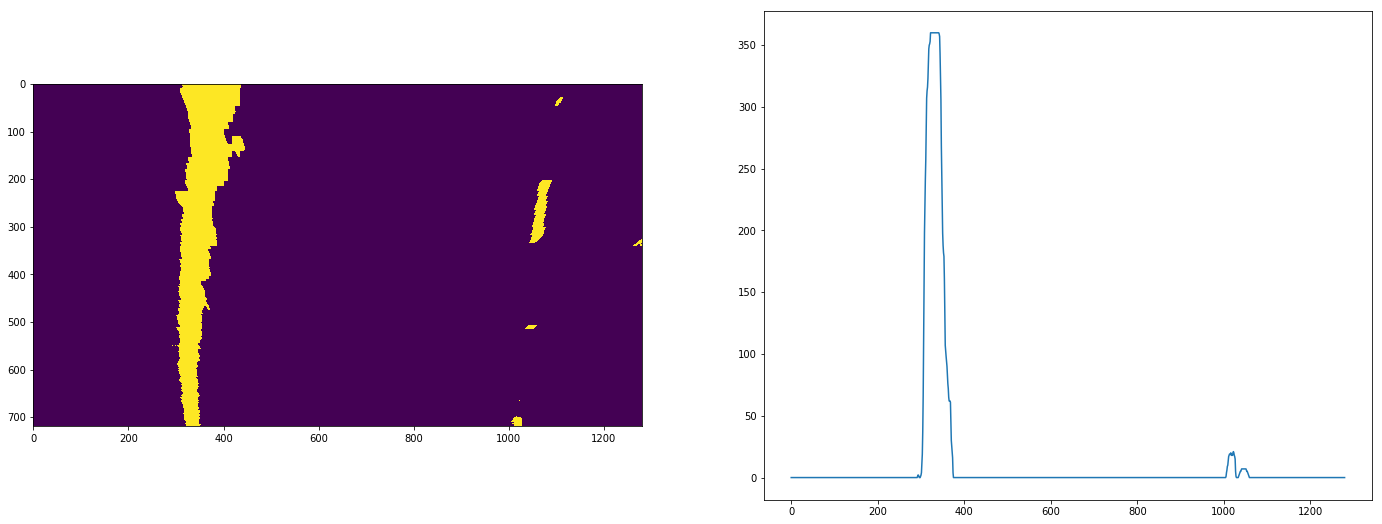

In [238]:
'''
if you want to sum value up each line, axis is 0.
At numpy, // means round down.
'''

# Sum vertical value up. 
# I first take a histogram along all the columns in the lower half( combined_binary.shape[0]//2 ) of the image like this:
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
print(warped_image.shape)
print(warped_image.shape[0]//2)
print(histogram.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(warped_image)
ax2.plot(histogram)


In [247]:
# windows settings
window_width = 100
window_height = 10
margin = 100

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[ \
           int(img_ref.shape[0]-(level+1)*height) : int(img_ref.shape[0]-level*height), \
           max(0, int(center-width/2)) : min(int(center+width/2), img_ref.shape[1])\
        ] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = []
    window = np.ones(window_width)

    '''
    '''
    l_sum = np.sum(image[int(3*image.shape[0]/4):, :int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):, :int(image.shape[1]/2)], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(image.shape[1]/2)
    
    '''
    '''
    window_centroids.append((l_center, r_center))
    
    '''
    '''
    for level in range(0, (int)(image.shape[0]/window_height)):
        '''
        '''
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        '''
        '''
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        '''
        '''
        window_centroids.append((l_center, r_center))
    
    return window_centroids

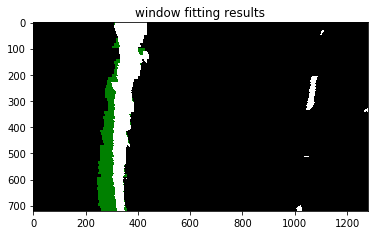

In [248]:
window_centroids = find_window_centroids(warped_image, window_width, window_height, margin)
warped = warped_image

if len(window_centroids) > 0:
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    for level in range(0, len(window_centroids)):
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        
        l_points[(l_points == 255) | ((l_mask == 1))] =255
        r_points[(r_points == 255 | ((r_mask == 1)))] = 255
        
    template = np.array(r_points + l_points, np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    warpage = np.dstack((warped, warped, warped))*255
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

plt.imshow(output)
plt.title('window fitting results')
plt.show()